In [64]:
import os

import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


import torch
from torch import nn
from torch.nn import functional as F

from torchvision.datasets import MNIST
from torchvision import transforms as tfs

from torch.utils.data import TensorDataset, DataLoader

import cv2

from collections import Counter

plt.style.use('dark_background')

In [15]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

In [19]:
Counter(y)

Counter({np.int64(1): 5000, np.int64(0): 5000})

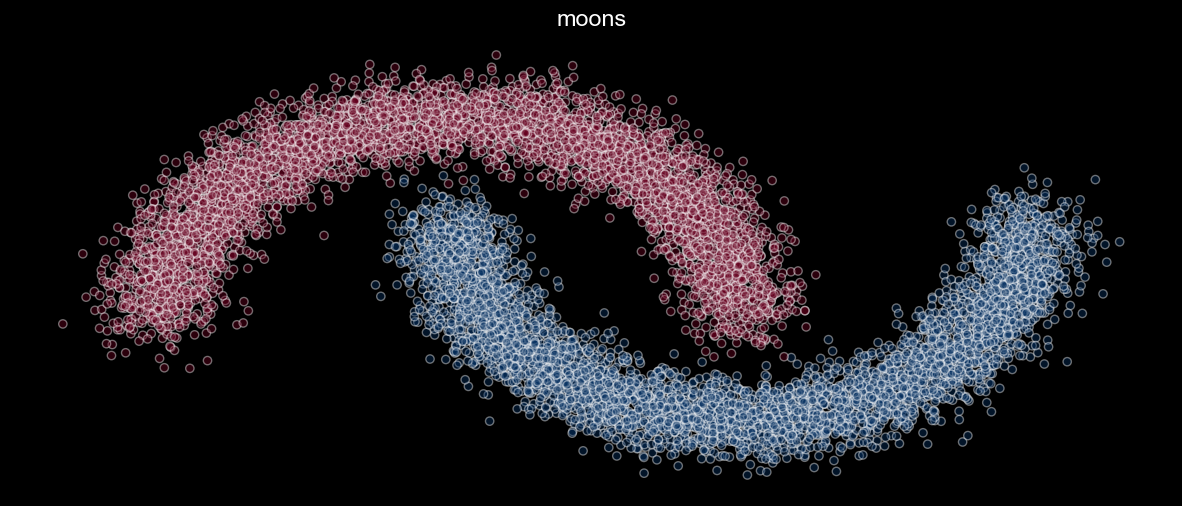

In [20]:
plt.figure(figsize=(15, 6))
plt.title('moons')
plt.scatter(
    X[:, 0], X[:, 1],
    c=y,
    cmap='RdBu',
    alpha=0.42,
    ec='white'
)
plt.axis('off')
plt.show()


In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [24]:
X_train_t = torch.from_numpy(X_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)

y_train_t = torch.from_numpy(y_train).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

In [25]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## логистическая регрессии

In [26]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x =  x @ self.weights
        if self.bias:
            x +=  self.bias
        return x

In [27]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

In [30]:
total_params = sum(p.numel() for p in linear_regression.parameters() if 
                   p.requires_grad)
print(total_params)

3


In [31]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch).view(-1)
        loss =  loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break   

Iteration: 0
Batch accuracy: 0.484375
Iteration: 100
Batch accuracy: 0.828125
Iteration: 200
Batch accuracy: 0.8671875
Iteration: 300
Batch accuracy: 0.890625
Iteration: 400
Batch accuracy: 0.8828125
Iteration: 500
Batch accuracy: 0.9296875
Iteration: 600
Batch accuracy: 0.8515625
Iteration: 700
Batch accuracy: 0.8515625
Iteration: 800
Batch accuracy: 0.875

Iteration: 814.Convergence. Stopping iterations.


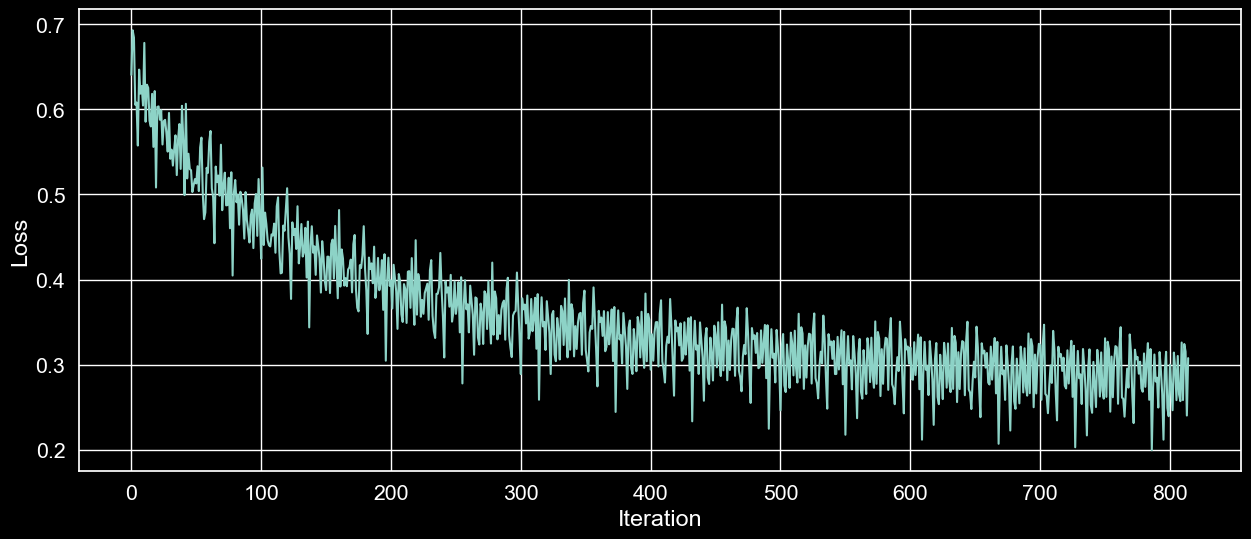

In [33]:
plt.figure(figsize=(15, 6))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

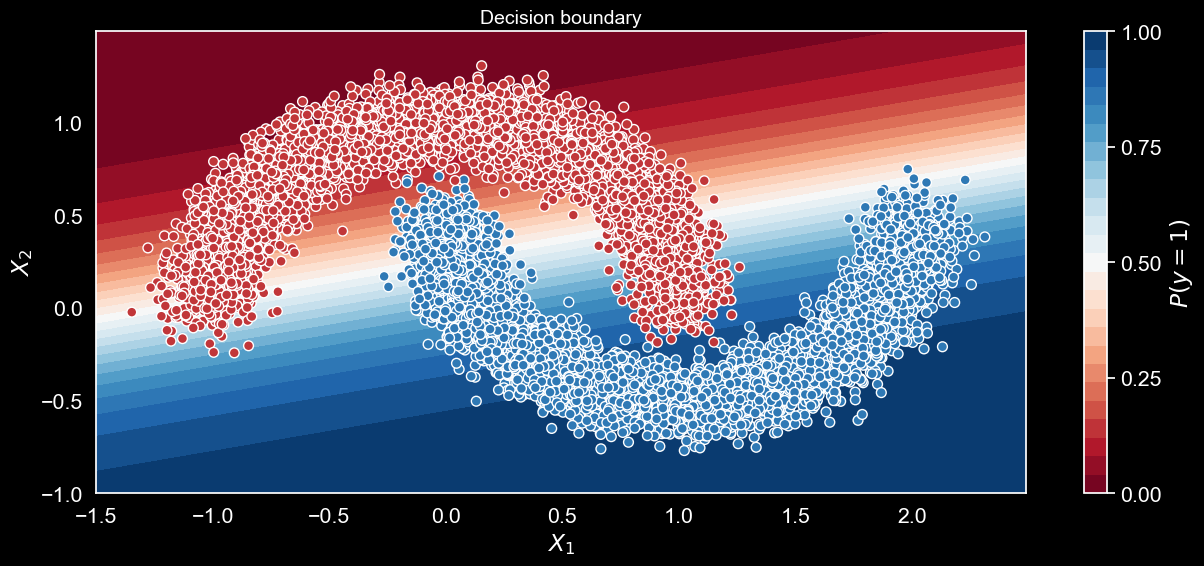

In [35]:
xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(15, 6))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = linear_regression(x_batch)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()


In [41]:
y_pred_logits = predict(val_dataloader, linear_regression)

y_pred = (torch.sigmoid(torch.tensor(y_pred_logits)) > 0.5).long().numpy()
y_true = np.concatenate([y_batch.numpy() for _, y_batch in val_dataloader])

accuracy = accuracy_score(y_true, y_pred)
print(f"accuracy: {accuracy:.2f}")

accuracy: 0.89


In [42]:
with torch.no_grad():
    torch.cuda.empty_cache()

# Часть 2. Датасет MNIST

In [44]:
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=128)
valid_dataloader =  DataLoader(val_dataset, batch_size=128)

100.0%
100.0%
100.0%
100.0%


In [49]:
# Получаем один батч из train_dataloader
for x_batch, y_batch in train_dataloader:
    in_channels, height, width = x_batch.shape[1:]
    input_size = in_channels * height * width    
    break 


In [45]:
class Identical(nn.Module):
    def forward(self, x):
        return x

In [55]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_size, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

device = "cuda" if torch.cuda.is_available() else "cpu"

In [54]:
max_epochs = 10
accuracy = {"train": [], "valid": []}

for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        if k == "train":
            model.train()
        else:
            model.eval()
        
        epoch_correct = 0
        epoch_all = 0

        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            if k == "train":
                optimizer.zero_grad()
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
            else:
                with torch.no_grad():
                    outputs = model(x_batch)

            preds = outputs.argmax(dim=1)
            correct = (preds == y_batch).sum()
            total = y_batch.size(0)

            epoch_correct += correct.item()
            epoch_all += total

        acc = epoch_correct / epoch_all
        accuracy[k].append(acc)

        if k == "train":
            print(f"\nEpoch {epoch+1}:")
        print(f"Loader: {k}. Accuracy: {acc:.4f}")



Epoch 1:
Loader: train. Accuracy: 0.8813
Loader: valid. Accuracy: 0.9297

Epoch 2:
Loader: train. Accuracy: 0.9438
Loader: valid. Accuracy: 0.9515

Epoch 3:
Loader: train. Accuracy: 0.9612
Loader: valid. Accuracy: 0.9573

Epoch 4:
Loader: train. Accuracy: 0.9692
Loader: valid. Accuracy: 0.9630

Epoch 5:
Loader: train. Accuracy: 0.9748
Loader: valid. Accuracy: 0.9643

Epoch 6:
Loader: train. Accuracy: 0.9786
Loader: valid. Accuracy: 0.9657

Epoch 7:
Loader: train. Accuracy: 0.9821
Loader: valid. Accuracy: 0.9669

Epoch 8:
Loader: train. Accuracy: 0.9844
Loader: valid. Accuracy: 0.9728

Epoch 9:
Loader: train. Accuracy: 0.9858
Loader: valid. Accuracy: 0.9716

Epoch 10:
Loader: train. Accuracy: 0.9881
Loader: valid. Accuracy: 0.9707


In [56]:
def test_activation_function(activation, max_epochs=10):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_size, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, 10)
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    accuracy = []

    for epoch in range(max_epochs):
        model.train()
        for x_batch, y_batch in loaders["train"]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x_batch, y_batch in loaders["valid"]:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                outputs = model(x_batch)
                preds = outputs.argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

        val_acc = correct / total
        accuracy.append(val_acc)

    return accuracy

In [57]:
elu_accuracy = test_activation_function(nn.ELU)
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

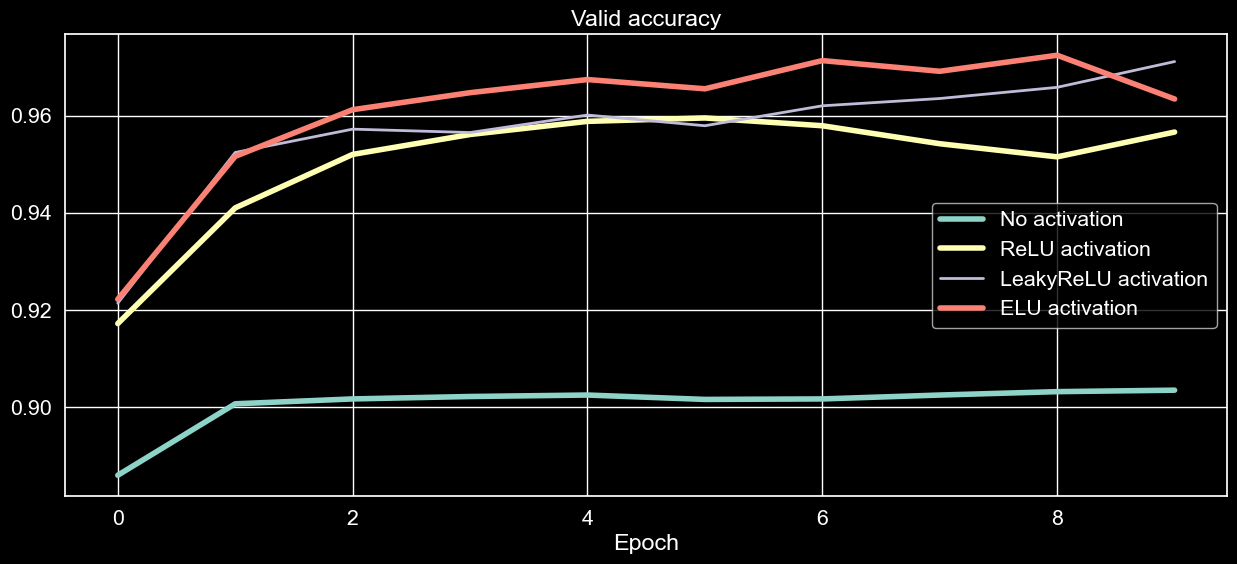

In [59]:
plt.figure(figsize=(15, 6))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=4)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=4)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=4)
plt.legend()
plt.xlabel("Epoch")
plt.show()

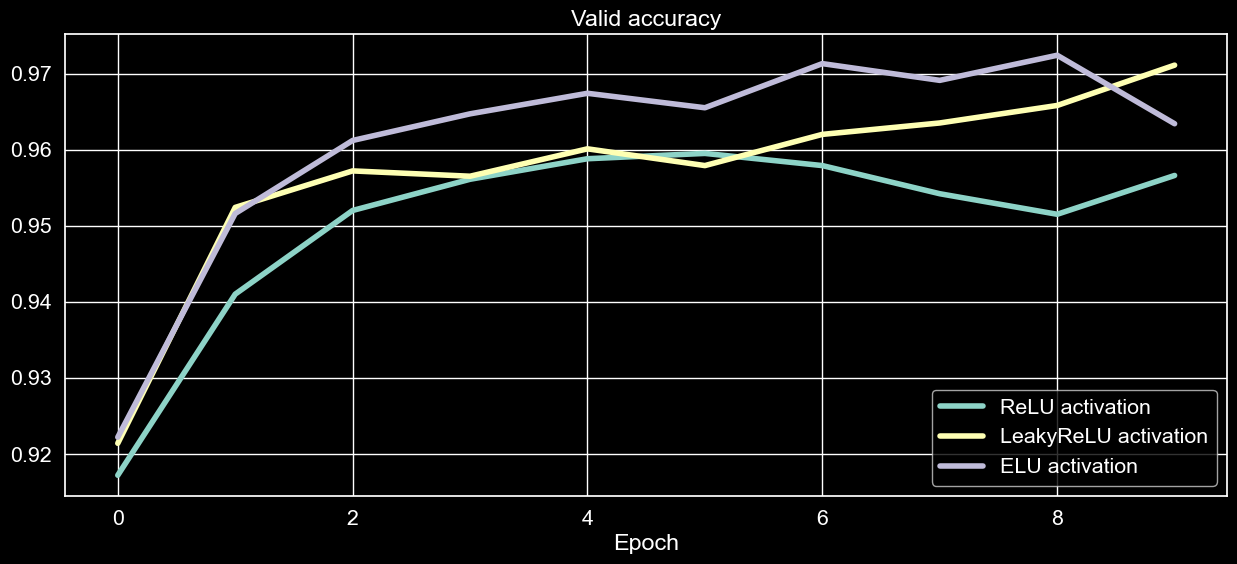

In [60]:
plt.figure(figsize=(15, 6))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=4)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=4)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=4)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [80]:
with torch.no_grad():
    torch.cuda.empty_cache()

## Сверточные нейронные сети

In [62]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2025-05-17 13:09:11--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   224KB/s    in 0.2s    

2025-05-17 13:09:12 (224 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



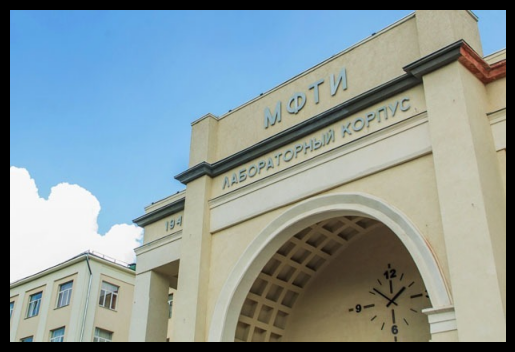

In [67]:
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(RGB_img)
plt.axis('off')
plt.show()

In [ ]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2) 
img_t = nn.ReflectionPad2d(1)(img_t)

result = F.conv2d(img_t, kernel)[0] 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1679688..1.4140625].


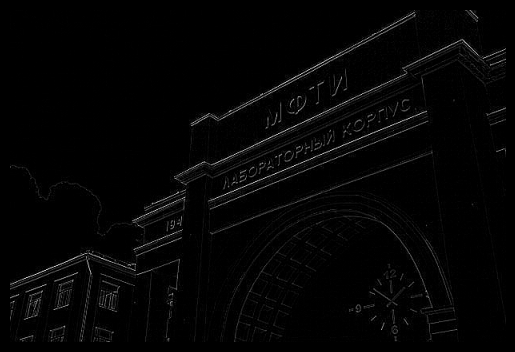

In [77]:
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.axis('off')
plt.show()

In [78]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.LazyLinear(120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.act = F.relu

    def forward(self, x):
        x = self.pool1(self.act(self.conv1(x)))

        x = self.pool2(self.act(self.conv2(x)))
        
        x = torch.flatten(x, 1)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.fc3(x)
        return x

In [79]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [81]:
max_epochs = 10
accuracy = {"train": [], "valid": []}

for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        if k == "train":
            model.train()
        else:
            model.eval()
        
        epoch_correct = 0
        epoch_all = 0

        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            if k == "train":
                optimizer.zero_grad()
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
            else:
                with torch.no_grad():
                    outputs = model(x_batch)

            preds = outputs.argmax(dim=1)
            correct = (preds == y_batch).sum()
            total = y_batch.size(0)

            epoch_correct += correct.item()
            epoch_all += total

        acc = epoch_correct / epoch_all
        accuracy[k].append(acc)

        if k == "train":
            print(f"\nEpoch {epoch+1}:")
        print(f"Loader: {k}. Accuracy: {acc:.4f}")



Epoch 1:
Loader: train. Accuracy: 0.8667
Loader: valid. Accuracy: 0.9437

Epoch 2:
Loader: train. Accuracy: 0.9583
Loader: valid. Accuracy: 0.9670

Epoch 3:
Loader: train. Accuracy: 0.9723
Loader: valid. Accuracy: 0.9769

Epoch 4:
Loader: train. Accuracy: 0.9796
Loader: valid. Accuracy: 0.9826

Epoch 5:
Loader: train. Accuracy: 0.9832
Loader: valid. Accuracy: 0.9848

Epoch 6:
Loader: train. Accuracy: 0.9862
Loader: valid. Accuracy: 0.9855

Epoch 7:
Loader: train. Accuracy: 0.9880
Loader: valid. Accuracy: 0.9868

Epoch 8:
Loader: train. Accuracy: 0.9898
Loader: valid. Accuracy: 0.9860

Epoch 9:
Loader: train. Accuracy: 0.9912
Loader: valid. Accuracy: 0.9869

Epoch 10:
Loader: train. Accuracy: 0.9926
Loader: valid. Accuracy: 0.9870


In [85]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [82]:
lenet_accuracy = accuracy["valid"]

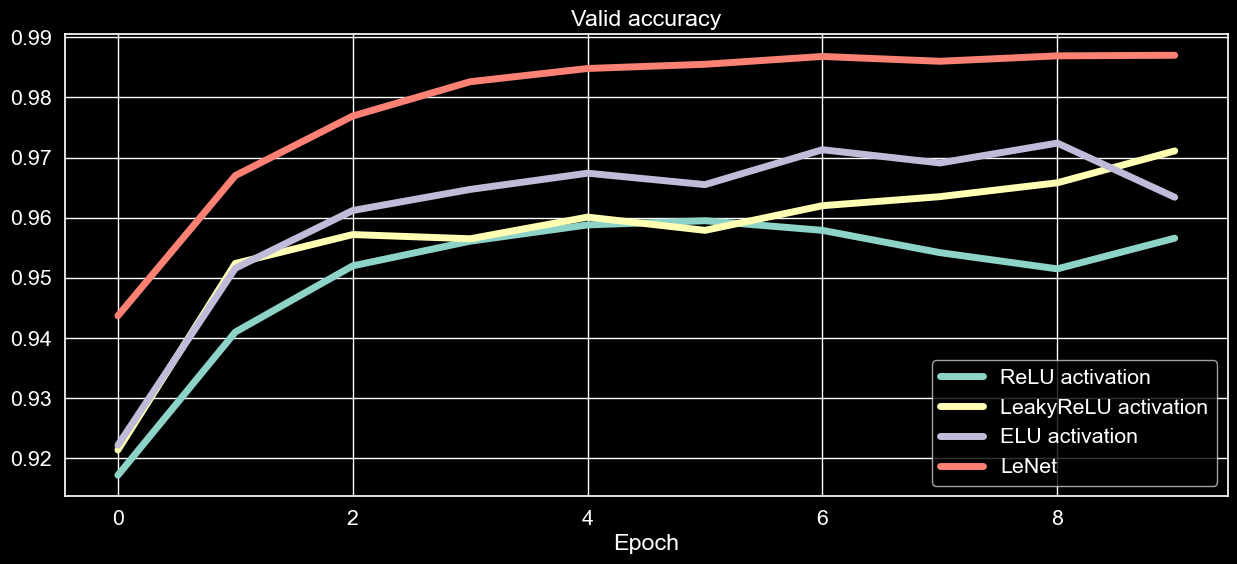

In [84]:
plt.figure(figsize=(15, 6))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=5)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=5)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=5)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=5)
plt.legend()
plt.xlabel("Epoch")
plt.show()